In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('src')


from models import BeemGMM
from sklearn import datasets
import numpy as np
from evaluation import eval_cluster
import pandas as pd
from scipy.constants import golden
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

# Example: How to replicate the Rainbow expermiment

#### Helper function for data set visualisation

In [2]:
def draw_data(X,y):
    standardFigureSize = (7, 7 / golden)
    # colors = np.asarray(['r', 'b', 'g', 'k', 'magenta'])
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    K = np.max(y) + 1
    bounds = np.linspace(0, K, K + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=standardFigureSize)
    plt.xlabel('$x0$')
    plt.ylabel('$x1$')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, norm=norm, edgecolors='k', alpha=0.5, s=7 ** 2)
    plt.grid()
    plt.axis('equal')
    # plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.15)
    
    plt.show()

#### Generate data from the "Rainbow" simulation

In [3]:
K = 8 #Number of clusters
r = 9 #Circle radious
n_runs = 10 # Number of times to repeat the experiment

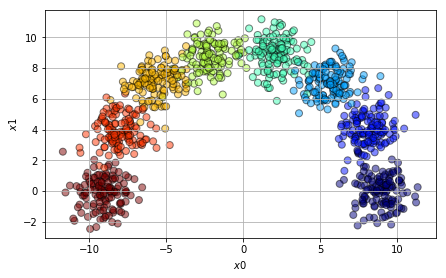

In [4]:
K = 8 #Number of clusters
r = 9 #Circle radious
means = []
for i in range(K):
    ang = (np.pi) / (K - 1) * i  #
    cplx = r * np.exp(1j * ang)
    x = np.real(cplx)
    y = np.imag(cplx)
    means.append([x, y])

X, y = datasets.make_blobs(n_samples=1000, centers=means,shuffle = True)
draw_data(X,y)

#### Fit a GMM via Boltzmann exploration expectation maximisation and compute metrics

In [5]:
statistics = []
for i in range(n_runs):
    #Define beem model object
    beem = BeemGMM(n_components=K,use_prior=False,patience=10,init='random',decay=0.97,tau=1.5)
    
    #Fit the mixture via Boltzmann exploration expectation maximization
    scores,tau,bincounts = beem.fit(X)
    
    #Assign each observation to a mixture component
    y_pred = beem.predict(X)
    
    #Compute metrics
    metric_dict = eval_cluster(y_pred,y)
    
    #Store statistics
    statistics.append(metric_dict)

#Print results
stats_df = pd.DataFrame(statistics)
print(stats_df.describe())


             ACC        ARS       HOMO        NMS
count  10.000000  10.000000  10.000000  10.000000
mean    0.955500   0.909423   0.915830   0.915896
std     0.026374   0.040735   0.023293   0.023261
min     0.905000   0.831703   0.870960   0.871099
25%     0.966250   0.924996   0.923586   0.923643
50%     0.967500   0.927676   0.926376   0.926435
75%     0.969000   0.930805   0.928097   0.928138
max     0.969000   0.930865   0.929286   0.929352


#### Fit a GMM via expecation maximisation and compute metrics

In [6]:
statistics = []
for i in range(n_runs):
    gmm = GMM(n_components=K,init_params='random',n_init = 1)
    gmm.fit(X)
    y_pred =gmm.predict(X)
    metric_dict = eval_cluster(y_pred,y)
    statistics.append(metric_dict)

stats_df = pd.DataFrame(statistics)
print(stats_df.describe())

             ACC        ARS       HOMO        NMS
count  10.000000  10.000000  10.000000  10.000000
mean    0.427700   0.328040   0.465657   0.615421
std     0.061763   0.078351   0.068974   0.064042
min     0.357000   0.175529   0.350962   0.512080
25%     0.378750   0.280359   0.429580   0.592402
50%     0.410000   0.344256   0.478467   0.624278
75%     0.461500   0.391140   0.505802   0.660527
max     0.543000   0.414525   0.554524   0.707006


# --------

## Visualisation of beem learning procedure

In [44]:
# Helper functions for visualisation
def plot_training(ax1,tau,scores):
  
    ln1=ax1.plot(tau,'r',label=' $\\tau$ ')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel(' $\\tau$ ',rotation=0,fontsize = 16,labelpad=15)
    ax1.grid()
    ax2 = ax1.twinx()
    ln2 = ax2.plot(scores,label='Likelihood')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Mean observation log-likelihood')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0,fontsize = 'large')
    
def plot_decision_boundary(clf, X, Y):
    figsize = (7, 7 / golden)
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k');
    return Z

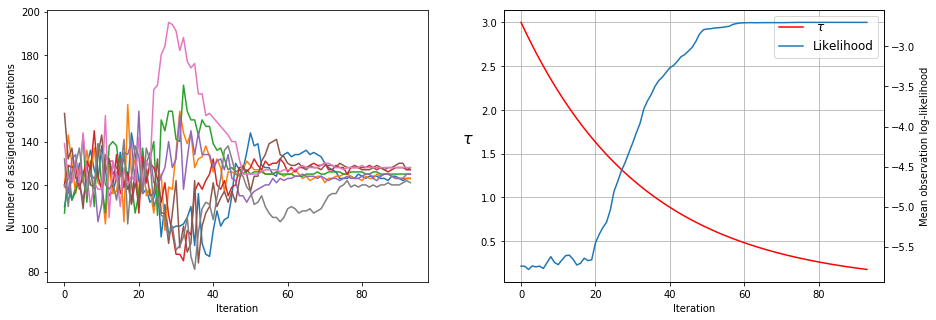

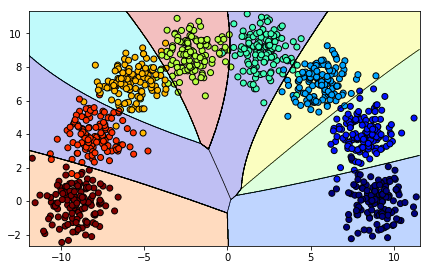

In [45]:
#Define beem 

#Here we set tau = 3 to show how the algorithm behaves unde excessive exploration. 
beem = BeemGMM(n_components=K,use_prior=False,patience=10,init='random',decay=0.97,tau=3)

#Fit the mixture via Boltzmann exploration expectation maximization
scores,tau,bincounts = beem.fit(X)

#number of samples assigned to each cluster at every iteration
bincounts = np.asarray(bincounts)


fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(bincounts)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Number of assigned observations')

plot_training(ax[1],tau,scores)
plt.show()

plot_decision_boundary(beem,X,y)
plt.show()